In [1]:
from htke.load_data import *
from htke.process_ir_data import *
from htke.load_conditions import *
from htke.spka import *
pd.options.mode.chained_assignment = None  # default='warn' stops the slice error

### Go to directory

In [2]:
cd ir_data/GL-05-52/

C:\Users\Paul Dingwall\Documents\github\htke\ir_data\GL-05-52


### Load Raw Data

In [3]:
# Instantiate class
Data()

# Load data to dataframe
ir_data = Data.read()

# Visualise the data
#Data.plot(ir_data)

#ir_data

### Find the Peaks in the Raw Data

In [4]:
# Instantiate class - doesn't work as Peaks(ir_data), I have to use Peaks = Peaks(ir_data), why?
Peaks = Peaks(ir_data)

,Prominence,Height,Experimental Area,Fitted Area
0,-0.998233,-0.998419,-0.999438,-0.999146
1,-0.994728,-0.994768,-0.998561,-0.997796
2,-0.997984,-0.997953,-0.999913,-0.999242
3,-0.998309,-0.997940,-0.999735,-0.999613
Sum,-3.989255,-3.989080,-3.997647,-3.995797


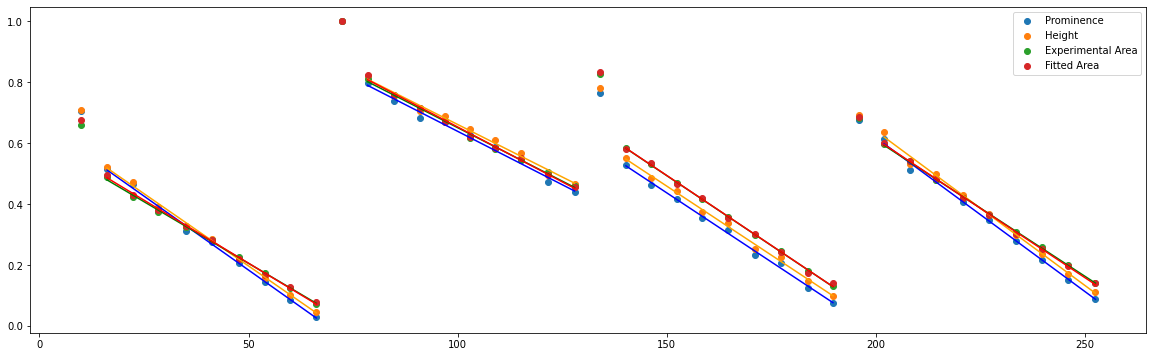

In [5]:
# Determine the peak prominences of every wavelength
#processed_ir_data = Peaks.prominence_all(0.032)

# Determine the peak prominences of a single wavelength
#processed_ir_data = Peaks.prominence(0.032,'Peak at 1704 cm-1')

# Determine the peak heights of a single wavelength
#processed_ir_data = Peaks.height(0.0505,'Peak at 1704 cm-1')

# Determine the experimental areas of a single wavelength
#processed_ir_data = Peaks.exp_area(0.032, 4, 'Peak at 1704 cm-1')

# Determine the fitted areas of a single wavelength
#processed_ir_data = Peaks.fitted_area(0.032, 4, 'Peak at 1704 cm-1')

# Fit a gaussian to a single peak and determine it's area
#processed_ir_data= Peaks.fitted_area_sp(0.05, 4, 'Peak at 1704 cm-1', 1.1, -0.4, 8)

# Compare prominence, height, experimental area, and fitted area
r2, compare = Peaks.compare(0.0505, 0.032, 4,'Peak at 1704 cm-1', 4, 10, 1.1, -0.4)
# NOTE: Areas seem to give the best value when the starting point is exactly on the peak (no baseline before)

# Visualise which peaks have been picked - single peak
#Peaks.plot(processed_ir_data, 'Peak at 1704 cm-1')

#processed_ir_data
r2

### Read experimental conditions and add to dataframe

In [6]:
Conditions()
experimental_data = Conditions.read(compare)
#experimental_data

Inputs seem good: IR Datapoints =  40 , Number of conditions =  40


### Create the SPKA profiles

In [7]:
SPKA2 = SPKA(experimental_data)

,Prominence,Height,Experimental Area,Fitted Area,Reaction
0,0.930686,0.954177,0.993290,0.986250,Exp1 - R1
1,0.786798,0.820344,0.947870,0.869733,Exp1 - R2
2,0.978877,0.981934,0.999063,0.994159,Exp1 - R3
3,0.702788,0.769898,0.994435,0.989865,Exp1 - R4
Sum,3.399149,3.526353,3.934659,3.840007,Sum


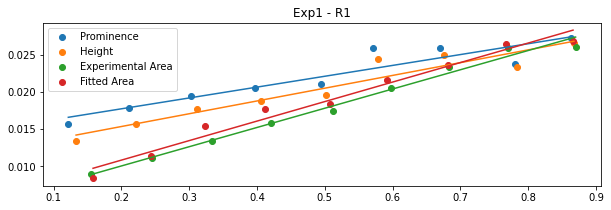

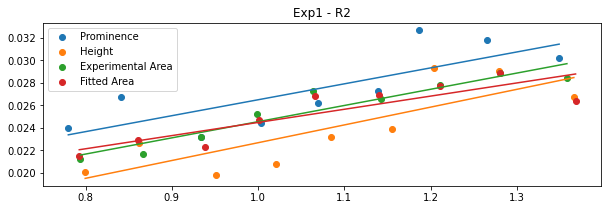

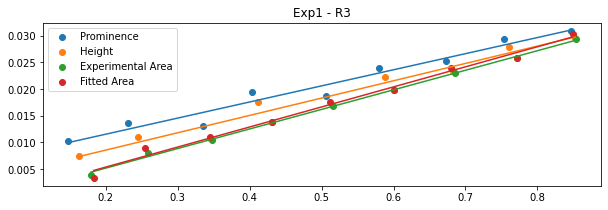

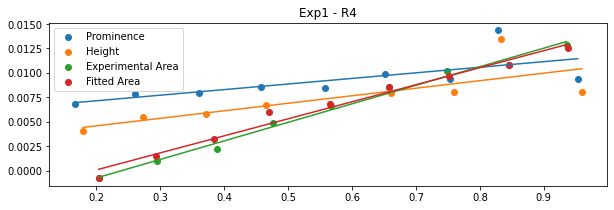

In [8]:
#spka_data = SPKA2.spka('[A]0')
#SPKA.plot(spka_data)
#spka_data
r2 = SPKA2.compare('[A]0')
r2

In [9]:
def gaussian(x, a, b, c):
    return a*np.exp(-np.power(x - b, 2)/(2*np.power(c, 2)))

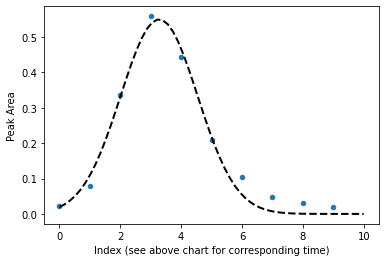

In [12]:
peak_threshold = 0.05
residence_time = 4
peak_of_interest = 'Peak at 1704 cm-1'
time_adjust_before = 1.1
time_adjust_after = -0.4
picked_peak = 1
p0 = [5, -1.5, 2]

# Requires prominence data (don't use prominence function as don't want returned processed_ir_data)
# Find single peak
x = ir_data[peak_of_interest]

# Find peak height and position
peaks = find_peaks(x, prominence = peak_threshold)
peak_prominence = peaks[1]
peak_pos = ir_data['Relative Time'][peaks[0]]

# Make it a list
list_of_peaks = list(peak_pos)

# Find a single peak - Adjusted slightly to account for tailing
single_peak = ir_data.loc[(ir_data['Relative Time'] >= list_of_peaks[picked_peak] - (residence_time/2 - time_adjust_before)) 
                        & (ir_data['Relative Time'] <= list_of_peaks[picked_peak] + (residence_time/2 + time_adjust_after))]

# Baseline correction - Make the first point 0 - MAKES THINGS WORSE!!
#single_peak[peak_of_interest] = single_peak[peak_of_interest] - single_peak[peak_of_interest].iloc[0]

# Fit Gaussian 
X = np.arange(0, len(single_peak))
pars, cov = curve_fit(f=gaussian, xdata=X, ydata=single_peak[peak_of_interest], p0 = p0, bounds=(-np.inf, np.inf))

# Plot curves
plt.scatter(X, single_peak[peak_of_interest], s=20, label='Data')
x = np.linspace(0, len(single_peak), 60)
plt.plot(x, gaussian(x, *pars), linestyle='--', linewidth=2, color='black')
plt.xlabel("Index (see above chart for corresponding time)")
plt.ylabel("Peak Area")
plt.show()